In [1]:
import os
import sys
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import math
import scipy.stats as stats


import import_ipynb
from CustomDataset import ControlsDataset
from Model import ConvNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print('using device', device)

importing Jupyter notebook from CustomDataset.ipynb
importing Jupyter notebook from Model.ipynb
using device cuda


In [2]:
torch.cuda.empty_cache()

In [3]:
dataset = ControlsDataset()
dataset.labels.num_categories = 21
dataset.labels.transform.categorize(1.05, -1.05, 21)
dataset.images.set_grayscale(False)
print("Data size", len(dataset.labels))
dataset.make_dataloaders()

Data size 11019
Total training stacks 69
Total validation stacks 18


In [4]:
net = ConvNet(color_channels = 3, outputs = 21, dataset = dataset).to(device)
#net = ConvNet(color_channels = 1, outputs = 21, dataset = dataset).to(device)
print("number of parameters: ", sum(p.numel() for p in net.parameters()))

units after conv 512
conv parameters:  168224
fc parameters:  166933
number of parameters:  335157


ID  Angle  Category
0          0    0.0        10
1          1    0.0        10
2          2    0.0        10
3          3    0.0        10
4          4    0.0        10
...      ...    ...       ...
11014  11014    0.0        10
11015  11015    0.0        10
11016  11016    0.0        10
11017  11017    0.0        10
11018  11018    0.0        10

[11019 rows x 3 columns]
[  80   50   76   86  146  219  418  378  874 1142 6655  236  154   62
   95   98   73   27   47    4   99]
21


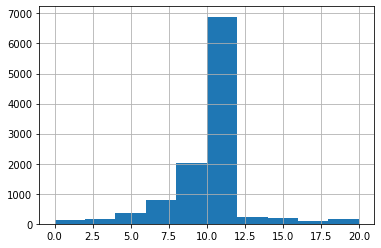

In [7]:
print(dataset.labels.dataframe)
counts = dataset.labels.dataframe.groupby('Category')['ID'].count()
array = np.array(counts)
print(array)
print(len(array))
dataset.labels.histogram()
# weights = max(counts)/array
# weights = torch.Tensor(weights).to(device)
# print(weights)
ratio = max(counts)/array



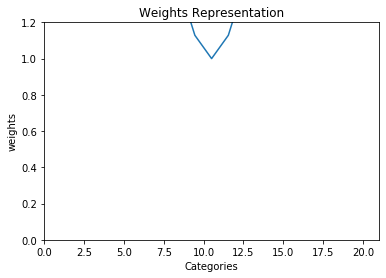

tensor([1.6637e+03, 2.6620e+03, 1.7512e+03, 1.5468e+03, 9.0845e+02, 5.9807e+02,
        3.0087e+02, 3.0118e+02, 1.0841e+02, 6.5777e+01, 1.0000e+01, 3.1829e+02,
        6.1527e+02, 1.8362e+03, 1.3238e+03, 1.3365e+03, 1.8169e+03, 4.9268e+03,
        2.8317e+03, 3.3275e+04, 1.3444e+03], device='cuda:0')


In [8]:
mu, variance = 10.5, 4
sigma = math.sqrt(variance) 
x = np.linspace(0, 21, 21)
pdf = stats.norm.pdf(x, mu, sigma)
inv = ((np.ones(len(x)) * (max(pdf))) - pdf)/max(pdf) + 1

plt.xlim([0,21])
plt.ylim([0,1.2])
plt.plot(x, inv)
plt.title("Weights Representation")
plt.xlabel("Categories")
plt.ylabel("weights")
plt.show()

weights = ratio * inv * 10
weights = torch.Tensor(weights).to(device)
print(weights)

In [9]:
from scipy.stats import uniform

uniform.cdf([0, 1, 2, 3, 4, 5], loc=1, scale=4)

array([0.  , 0.  , 0.25, 0.5 , 0.75, 1.  ])

In [12]:
epochs = 30
optimizer = optim.Adam(net.parameters(), lr=0.0001)
print(type(weights))
criterion = nn.CrossEntropyLoss(weight=weights) # Changed from Mean-Squared to Cross-Entropy
#criterion = nn.MSELoss()
net.report_period = 20

net.optimizer = optimizer
#net.load("snapshots/1.217_model.pt")

net.fit(device,epochs,optimizer,criterion)

<class 'torch.Tensor'>
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([10, 12, 10, 10, 10,  8, 10, 10, 10, 10, 10, 17, 11,  8, 10, 10, 10, 11,
        10,  9, 11, 10, 10, 10,  9, 10, 10, 10,  9, 10, 10,  8, 10, 10, 20, 13,
        12,  8, 10,  9, 10,  9,  9, 10, 10, 10,  8, 10, 10,  9,  9, 10, 10,  8,
        18,  9,  3,  7, 10,  9, 10, 10,  8, 10, 10, 10, 11,  9, 10, 10, 10, 10,
        11, 10,  3, 10, 12,  9, 20, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10,
        10, 10,  9, 10, 10,  9, 10, 10, 11,  6,  8,  9, 10, 10,  5,  4,  9, 10,
        10, 10, 10, 10, 10, 10, 10,  4, 10, 10,

Accuracy: 3.125%
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([ 9, 10, 10, 10, 10,  9, 14, 15,  5, 10, 10,  1,  8, 13,  5, 10, 15, 10,
        10,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  8, 10,  6,
        10,  6, 10, 10, 10,  5, 10, 14,  9,  8, 10, 10, 10,  7, 10, 10, 10,  7,
        10,  7, 10, 10, 10, 10,  8, 10, 10, 10, 10,  9, 10, 10,  6, 10, 10, 10,
        10,  6, 10,  9, 10,  9,  9,  8, 10, 10, 10,  8, 10, 10,  8, 10, 10,  7,
         0,  8, 10, 10,  8, 10, 10,  9, 10, 10,  4,  8, 10, 10,  8, 10,  2,  9,
         4, 10,  9,  5, 10, 10, 10, 10,  9,  6,  9, 1

KeyboardInterrupt: 

In [13]:
# End of training Validation Test
#net.load("snapshots/0.727_model.pt")
#total, correct = net.score(device,dataset, "categorical")

total = 0
correct = 0
for i_batch, sampled_batch in enumerate(dataset.validloader):
    images = sampled_batch['image'].to(device).float()
    controls = sampled_batch['control'].to(device).long()
    controls = torch.flatten(controls)
    prediction = net(images)

    maximum = torch.argmax(prediction,dim = 1)
    print(maximum)
    print(controls)
    shared = maximum == controls
    shared = 1 * shared
    correct += int(torch.sum(shared))
    total += len(controls)



print("{:.1f}% classified correctly".format(100*correct/total))

tensor([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13], device='cuda:0')
tensor([10,  8, 10,  4,  3, 10, 10,  5, 10, 10, 10, 12, 10, 10, 10, 10, 10,  1,
        10,  7, 10,  7, 10, 10,  9, 10,  8, 10, 10, 10, 10, 10, 10,  9, 10,  9,
         9, 10,  2, 10, 10, 10, 10, 10,  7,  4,  8, 10,  6, 10, 10,  0,  9, 10,
         6,  1, 10, 10, 10,  9, 10, 10,  9, 10,  3, 10, 10, 10,  6,  8, 10, 10,
        10,  8,  2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9, 11,  7, 10,
      

RuntimeError: CUDA out of memory. Tried to allocate 900.00 MiB (GPU 0; 3.95 GiB total capacity; 988.18 MiB already allocated; 776.44 MiB free; 1.24 GiB cached)

In [14]:
# Beginning of training Validation Test
net.load("snapshots/3.002_model.pt")
total, correct = net.score(device,dataset, "categorical")
print("{:.1f}% classified correctly".format(100*correct/total))

FileNotFoundError: [Errno 2] No such file or directory: 'snapshots/3.002_model.pt'

In [10]:
# Function to compute adversarial noise given a trained net 
def compute_noise(net, lr, data_sample):
    input_img = data_sample['image'].to(device).float()
    control = data_sample['control'].to(device).long()
    
    # remember grad for image for adversarial attack
    input_img.requires_grad = True

    # pass img through the net 
    output = net(input_img)
    pred = torch.argmax(output, dim = 1)
    if pred != control:
        # nothing to fool if prediction aint right in the first place  
        return 0

    loss = F.nll_loss(output, control)
    # zero out gradients
    model.zero_grad()
    loss.backward()

    # get all the gradient data for computing adversarial noise 
    grads = input_img.grad.data

    # get element-wise sign of grad data
    # idk the tutorial did this: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
    grads_signs = grads.sign()

    # create adversarial noise
    adv_noise = lr*grads_signs

    # compute adverarial image by adding noise to input image
    adv_input = input_img + adv_noise

    # run net on adv_image and see if we succeded in fooling it 
    adv_output = net(adv_input)
    adv_pred = torch.argmax(adv_output, dim = 1)
    if adv_pred == control:
        # adv attack failed, either net is good or my code is bad 
        return -1
    else:
        return adv_noise, adv_input, pred, adv_pred, control


In [ ]:
torch.cuda.empty_cache()

In [ ]:
#Additional Info when using cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024))